# Convolution Neural Net (CNN)
to detect apples

# Imports

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pprint
import random
import torch
import torchvision
import torch.nn.functional as FF
import torchvision.transforms.functional as F
import torchvision.transforms as T
import wandb
from init.config import *
from datetime import datetime
from os import listdir, path
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from tqdm import tqdm

In [15]:
x = userAccountID 

print(x)


dyrr


In [16]:
# set the device

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
x = torch.ones(1, device=device)

print(f"Device is '{device}' Thus a tensor will look like this: {x}")

Device is 'mps' Thus a tensor will look like this: tensor([1.], device='mps:0')


In [17]:
# function to show an image from the dataloader with its label
def show_batch(train_d,test_d,val_d):
    # Get a batch of data from the DataLoader
    data_train = next(iter(train_d))
    data_test = next(iter(test_d))
    data_val = next(iter(val_d))

    # Set the savefig.bbox parameter to 'tight'
    plt.rcParams["savefig.bbox"] = 'tight'

    # Retrieve the first tensor and its corresponding label
    image_train = data_train[0][0]
    image_test = data_test[0][0]
    image_val = data_val[0][0]
    label_train = data_train[1][0]
    label_test = data_test[1][0]
    label_val = data_val[1][0]
  

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 3)


    # Convert the image tensor to a NumPy array and transpose the dimensions
    np_image_train = image_train.permute(1, 2, 0).numpy()
    np_image_test = image_test.permute(1, 2, 0).numpy()
    np_image_val = image_val.permute(1, 2, 0).numpy()
    

        # Display the original image in the first subplot
    axes[0].imshow(np_image_train)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[0].set_title(f'{label_train}, {image_train.shape}')

    # Display the pooled image in the second subplot
    axes[1].imshow(np_image_test)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[1].set_title(f'{label_test}, {image_test.shape}')

    # Display the pooled image in the third subplot
    axes[2].imshow(np_image_val)  # ,cmap='gray' after the image name to create a greyscale image.
    axes[2].set_title(f'{label_val}, {image_val.shape}')

    # Adjust spacing between subplots to prevent overlap
    fig.tight_layout()

    # Show the plot
    plt.show()

In [18]:
# function to determine accuracy 

def evaluate_accuracy(logits, y_true):
    # get index with the largest logit value PER OBSERVATION
    _, y_pred = torch.max(logits, dim=1)

    # calculate proportion of correct prediction
    correct_pred = (y_pred == y_true).float()  # PyCharm error Unresolved attribute reference 'float' for class 'bool'
    acc = correct_pred.sum() / len(correct_pred)

    return acc * 100

In [19]:
# function to train the model

def train(model, train_loader, val_loader, criterion, optimizer, n_epochs, model_file_name='model.pt'):
    # initialize container variable for model performance results per epoch
    history = {
        'n_epochs': n_epochs,
        'loss': {
            'train': [],
            'val': []
        },
        'acc': {
            'train': [],
            'val': []
        }
    }

    # initialize tracker for minimum validation loss
    val_loss_min = np.Inf

    # loop per epoch
    for epoch in tqdm(range(n_epochs)):
        # initialize tracker for training performance
        train_acc = 0
        train_loss = 0

        ###################
        # train the model #
        ###################

        # prepare model for training
        model.train()

        # loop for each batch
        for data, target in tqdm(train_loader):
            # move data to device
            data, target = data.to(device), target.to(device)
            
            # STEP 1: clear gradients
            optimizer.zero_grad()
            # STEP 2: forward pass
            output = model(data)
            # STEP 3: calculate the loss
            loss = criterion(output, target)
            # STEP 4: backward pass
            loss.backward()
            # STEP 5: perform parameter update
            optimizer.step()
            # STEP 6: accumulate training loss and accuracy
            train_loss += loss.item() * data.size(0)
            acc = evaluate_accuracy(output, target)
            train_acc += acc.item() * data.size(0)

        ######################
        # validate the model #
        ######################

        # disable gradient calculation
        with torch.no_grad():
            # initialize tracker for validation performance
            val_acc = 0
            val_loss = 0

            # prepare model for evaluation
            model.eval()

            # loop for each batch
            for data, target in tqdm(val_loader):
                # move data to device
                data, target = data.to(device), target.to(device)
                # STEP 1: forward pass
                output = model(data)
                # STEP 2: calculate the loss
                loss = criterion(output, target)
                # STEP 3: accumulate validation loss and accuracy
                val_loss += loss.item() * data.size(0)
                acc = evaluate_accuracy(output, target)
                val_acc += acc.item() * data.size(0)

        ####################
        # model evaluation #
        ####################

        # calculate average loss over an epoch
        train_loss /= len(train_loader.sampler)
        val_loss /= len(val_loader.sampler)
        history['loss']['train'].append(train_loss)
        history['loss']['val'].append(val_loss)

        # calculate average accuracy over an epoch
        train_acc /= len(train_loader.sampler)
        val_acc /= len(val_loader.sampler)
        history['acc']['train'].append(train_acc)
        history['acc']['val'].append(val_acc)

        # print training progress per epoch
        print(f'Epoch {epoch+1:03} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}')

        # save model if validation loss has decreased
        if val_loss <= val_loss_min:
            print(
                f'Validation loss decreased ({val_loss_min:.5f} --> {val_loss:.5f})  Saving model to {model_file_name}...')
            torch.save(model.state_dict(), model_file_name)
            val_loss_min = val_loss

        print()

    # return model performance history
    return history

In [20]:
# load the dataset
dataset_path = "build/Practicum/pics/2750"
transform = T.ToTensor()
dataset = ImageFolder(dataset_path, transform=transform)



dataset.class_to_idx
pp = pprint.PrettyPrinter(indent=1)  # Create a PrettyPrinter instance with an indentation of 1 space
pp.pprint(dataset.class_to_idx)  # Use the pprint method to print the dictionary

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}


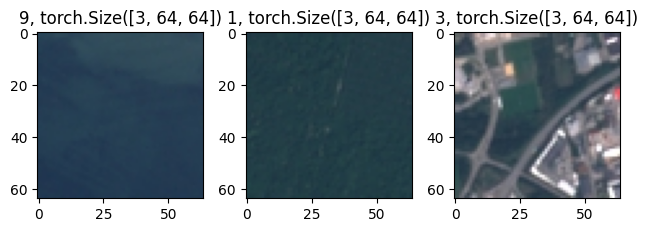

tensor([[[0.2353, 0.2353, 0.2392,  ..., 0.1882, 0.1843, 0.1843],
         [0.2392, 0.2392, 0.2392,  ..., 0.1882, 0.1843, 0.1843],
         [0.2392, 0.2353, 0.2353,  ..., 0.2000, 0.1843, 0.1922],
         ...,
         [0.2902, 0.2902, 0.2902,  ..., 0.2510, 0.2510, 0.2471],
         [0.2824, 0.2863, 0.2667,  ..., 0.2667, 0.2588, 0.2510],
         [0.2392, 0.2392, 0.2392,  ..., 0.2588, 0.2549, 0.2510]],

        [[0.3020, 0.3020, 0.2980,  ..., 0.3059, 0.3020, 0.3020],
         [0.2980, 0.2980, 0.2980,  ..., 0.3059, 0.3020, 0.3020],
         [0.2941, 0.2941, 0.2941,  ..., 0.3059, 0.2902, 0.2980],
         ...,
         [0.3333, 0.3333, 0.3333,  ..., 0.3098, 0.3098, 0.3059],
         [0.3373, 0.3412, 0.3176,  ..., 0.3255, 0.3176, 0.3098],
         [0.2980, 0.2980, 0.2902,  ..., 0.3176, 0.3137, 0.3098]],

        [[0.4196, 0.4196, 0.4275,  ..., 0.4157, 0.4118, 0.4118],
         [0.4196, 0.4196, 0.4275,  ..., 0.4157, 0.4118, 0.4118],
         [0.4078, 0.4157, 0.4235,  ..., 0.4118, 0.4039, 0.

In [21]:
# create the test, train and validation set and the dataloader

# setup split data 
dataset_size = len(dataset)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


# Set the seed for the generator
seed = 42
generator = torch.Generator().manual_seed(seed)

# Calculate the number of samples for each split
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)


# Define the batch size for the DataLoader
batch_size = 128

# Create the DataLoader to load the dataset in batches
train_d = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_d = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_d = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Show the 1st img in the dataset
show_batch(train_d, test_d,val_d)
print(train_dataset[0][0])

In [22]:
# define the CNN model

class CNN(nn.Module):
    
    #-------------------------------------------------------
    
    def __init__(self, dropout=0):
        self.dropout = dropout
        

        # Because we inherit from Module base class
        super().__init__()
        
        # RGB input, 6 filters, kernel of 5 x 5
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # Filter is 2 x 2 with a stride of 2 (defined once, used two times)
        self.pool = nn.MaxPool2d(2, 2)
        
        # in_channels = 6 because self.conv1 output has 6 channels
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Fully connected layer matched on output of conv2 layer
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        
        # Dropout layer1
        self.dropout1 = nn.Dropout(self.dropout)    

        # Dropout layer2
        self.dropout2 = nn.Dropout(self.dropout)

        # Fully connected layer
        self.fc2 = nn.Linear(120, 84)
        
        # We only have 2 labels
        self.fc3 = nn.Linear(84, 10)
        
    #-------------------------------------------------------
        
    def forward(self, x):
        
        # Convolution with relu layers
        x = self.pool(FF.relu(self.conv1(x)))
        x = self.pool(FF.relu(self.conv2(x)))
        
        # To match the output of the conv2 layer onto the first fully connected layer
        # Like reshape() but makes no copy (reuses underlaying data)
        x = x.view(-1, 16 * 13 * 13)
        
        # Fully connected layers
        x = FF.relu(self.fc1(x))
        x = self.dropout1(x)
        x = FF.relu(self.fc2(x))
        x = self.dropout2(x)
        
        # No activation on final layer 
        return self.fc3(x)


In [23]:
# set the hyperparameters and the model

# hyperparameters
learning_rate = 0.01
epochs = 1
momentum = 0.9
total_epochs =0
dropout = 0.2


# model parameters

model = CNN(dropout=dropout) # Create the model
model.to(device) # set model to device
model.train() # set model to train mode

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# loss function
criterion = nn.CrossEntropyLoss()   # Define the loss function  
 
 # set the loaders to the correct names for the training loop
train_loader = train_d
val_loader = val_d

# set epochloss to empty list
epoch_loss = []

In [32]:
# create dictionairies for the hyperparameters and model parameters
hyperparameters = { 'learning_rate' : learning_rate, 'epochs' : epochs, 'momentum' : momentum, 'dropout' : dropout}
model_parameters = { 'model' : 'cnn', 'optimizer' : 'SGD', 'criterion' : 'CrossEntropyLoss'}  # 'model' : model, 'optimizer' : optimizer, 'criterion' : criterion

pp = pprint.PrettyPrinter(indent=1)  

pp.pprint(f'hyperparameters: {hyperparameters}')
print()
pp.pprint(f'model_parameters: {model_parameters}')

("hyperparameters: {'learning_rate': 0.01, 'epochs': 1, 'momentum': 0.9, "
 "'dropout': 0.2}")

("model_parameters: {'model': 'cnn', 'optimizer': 'SGD', 'criterion': "
 "'CrossEntropyLoss'}")


In [25]:
# the training loop
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
saveFileName = f'{timestamp}_{userAccountID}.pt'

history = train(
    model, train_loader, val_loader, criterion, optimizer, n_epochs=epochs,
    model_file_name=saveFileName
)

100%|██████████| 1/1 [00:26<00:00, 26.90s/it]

Epoch 001 | Train Loss: 2.29759 | Val Loss: 2.29422 | Train Acc: 11.26 | Val Acc: 12.57
Validation loss decreased (inf --> 2.29422)  Saving model to 20230602-000518_dyrr.pt...



In [33]:
from azure.cosmos import CosmosClient
import base64
from init.config import settings, userAccountID
from datetime import datetime

# from modelhyperparameters import runx   # import the model hyperparameters

# Retrieve settings from the config file
endpoint_uri = settings['host']
auth_key = settings['master_key']
database_name = settings['database_id']
container_name = settings['container_id']

# Create the Cosmos DB client
client = CosmosClient(endpoint_uri, auth_key)

# Get the database and container
database = client.get_database_client(database_name)
container = database.get_container_client(container_name)

# create a timestamp and a unique ID
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
unique_id = f'{timestamp}_{userAccountID}'

# get the .pth file and encode it to base64
pth_file_path = '/Users/stephandekker/workspace/pink_lady/20230602-000518_dyrr.pt'
with open(pth_file_path, 'rb') as file:
    pth_data = file.read()
pth_bytes = base64.b64encode(pth_data).decode('utf-8')



# create the item to be saved on Cosmos DB
# document = {'id': unique_id, 'pth_data': pth_bytes, 'runtime': timestamp, 'run_id': runx['run_id'], 'model': runx['model'], 'learn_rate': runx['learn_rate'], 'epochs': runx['epochs'], 'test_loss': runx['test_loss'], 'test_loss_epoch': runx['test_loss_epoch'], 'train_loss': runx['train_loss'], 'test_acc': runx['test_acc'], 'train_acc': runx['train_acc'], 'test_acc_epoch': runx['test_acc_epoch'], 'optimizer': runx['optimizer'], 'dropout': runx['dropout'], 'momentum': runx['momentum'], 'batch_size': runx['batch_size'], 'num_workers': runx['num_workers'], 'seed': runx['seed']}
document = {'id': unique_id, 'pth_data': pth_bytes, 'hyperparameters': hyperparameters, 'model_parameters': model_parameters}

container.create_item(document)
print('Item with id \'{0}\' created'.format(unique_id))


Item with id '20230602_0010_dyrr' created


test


In [35]:
# load the best model

from azure.cosmos import CosmosClient
import base64

import torch

# Retrieve settings from the config file
endpoint_uri = settings['host']
auth_key = settings['master_key']
database_name = settings['database_id']
container_name = settings['container_id']

# Create the Cosmos DB client
client = CosmosClient(endpoint_uri, auth_key)

# Get the database and container
database = client.get_database_client(database_name)
container = database.get_container_client(container_name)

# Retrieve the document containing the .pth data (assuming you know the unique_id)
unique_id = "20230602_0010_dyrr"
item = container.read_item(item=unique_id, partition_key=unique_id)

# Retrieve the pth_data from the item
pth_bytes = item['pth_data']

# Specify the path to save the .pth file
pth_file_path = f'/Users/stephandekker/workspace/pink_lady/noSQL/pth/imported/{unique_id}.pth'

# Decode and save the .pth data to a file
decoded_pth_data = base64.b64decode(pth_bytes)
with open(pth_file_path, 'wb') as file:
    file.write(decoded_pth_data)

# Retrieve the hyperparameters
hyperparameters = item['hyperparameters']

# Save the variable as a .pth file
torch.save(decoded_pth_data, pth_file_path)

# # print the hyperparameters
# print(hyperparameters)

In [37]:
test_loader = test_d
len(test_loader)

32

In [40]:
%%timeit
y_test = []
y_pred = []
counter = 0
# disable gradient calculation
with torch.no_grad():
    # prepare model for evaluation
    model.eval()

    # loop for each data
    for data, target in tqdm(test_loader):
        # move data to device
        data, target = data.to(device), target.to(device)

        counter += 1
        # STEP 1: forward pass
        output = model(data)
        # STEP 2: get predicted label
        _, label = torch.max(output, dim=1)
        # STEP 3: append actual and predicted label
        y_test += target.cpu().numpy().tolist()
        y_pred += label.cpu().numpy().tolist()
        print(counter)

print(f'End{counter}')

 28%|██▊       | 9/32 [00:01<00:03,  6.31it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14


 66%|██████▌   | 21/32 [00:02<00:00, 16.98it/s]

15
16
17
18
19
20
21
22
23
24
25
26


 88%|████████▊ | 28/32 [00:02<00:00, 24.39it/s]

27
28
29
30
31
32


100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


End32


 41%|████      | 13/32 [00:01<00:01,  9.53it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


 78%|███████▊  | 25/32 [00:01<00:00, 20.04it/s]

24
25
26
27
28
29
30
31
32


100%|██████████| 32/32 [00:12<00:00,  2.66it/s]


End32


 41%|████      | 13/32 [00:01<00:01,  9.67it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


 78%|███████▊  | 25/32 [00:01<00:00, 20.32it/s]

25
26
27
28
29
30
31
32


100%|██████████| 32/32 [00:12<00:00,  2.67it/s]


End32


 28%|██▊       | 9/32 [00:01<00:03,  6.63it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


 75%|███████▌  | 24/32 [00:02<00:00, 20.45it/s]

17
18
19
20
21
22
23
24
25
26
27
28
29
30


 97%|█████████▋| 31/32 [00:02<00:00, 26.79it/s]

31
32


100%|██████████| 32/32 [00:12<00:00,  2.63it/s]


End32


 28%|██▊       | 9/32 [00:01<00:03,  6.58it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14


 69%|██████▉   | 22/32 [00:02<00:00, 18.40it/s]

15
16
17
18
19
20
21
22
23
24
25
26


 91%|█████████ | 29/32 [00:02<00:00, 25.05it/s]

27
28
29
30
31
32


100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


End32


 28%|██▊       | 9/32 [00:01<00:03,  6.25it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14


 66%|██████▌   | 21/32 [00:02<00:00, 16.85it/s]

15
16
17
18
19
20
21
22
23
24
25
26


 88%|████████▊ | 28/32 [00:02<00:00, 24.23it/s]

27
28
29
30
31
32


100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


End32


 28%|██▊       | 9/32 [00:01<00:03,  6.30it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14


 66%|██████▌   | 21/32 [00:02<00:00, 16.99it/s]

15
16
17
18
19
20
21
22
23
24
25
26


 84%|████████▍ | 27/32 [00:02<00:00, 23.13it/s]

27
28
29
30
31
32


100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


End32


 41%|████      | 13/32 [00:01<00:01,  9.76it/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


 78%|███████▊  | 25/32 [00:01<00:00, 20.53it/s]

25
26
27
28
29
30
31
32


100%|██████████| 32/32 [00:11<00:00,  2.67it/s]

End32
12.2 s ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
